# Mapping problem using moscot  
from dissociated nPOD scRNAseq data to spatial data  
Dissociated data preprocced by Rebecca Melton from Gaulton's lab 

### Import packages

In [1]:
!pip install decoupler

In [2]:
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [1]:
import time
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
import moscot as mt
#from moscot import datasets
from moscot.problems.space import MappingProblem
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import scanpy as sc
import squidpy as sq

### Data sets

In [2]:
adata_sc = sc.read('/lustre/groups/ml01/datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/scrna/072424_npod_RNA_raw.h5ad')
adata_s1 = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1_annotated_l0.h5ad')

adata_sc, adata_s1

(AnnData object with n_obs × n_vars = 276906 × 36601
     obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
     obsm: 'X_harmony', 'X_pca', 'X_umap'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 108711 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_

### Subsetting and pre-processing

In [3]:
adata_s1.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

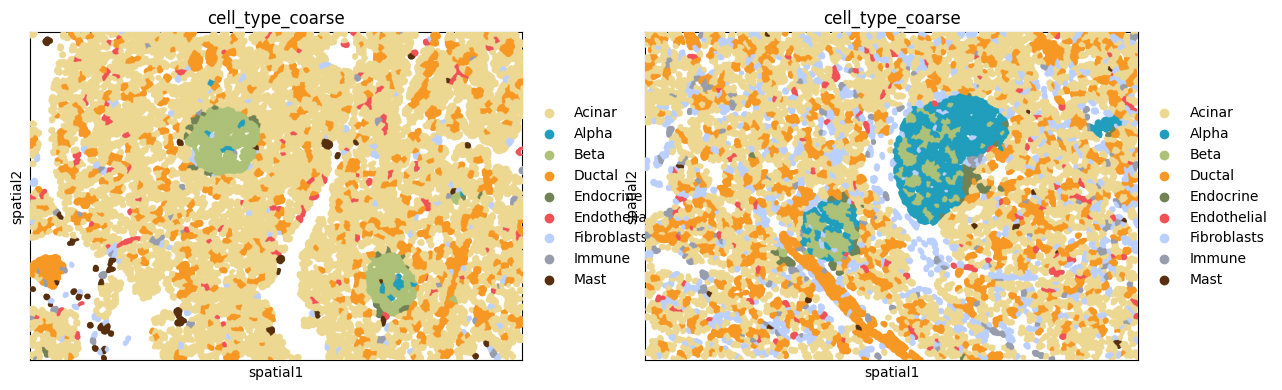

In [4]:
sq.pl.spatial_segment(adata_s1,color='cell_type_coarse',ncols=2,library_id=['10','12'],
                      library_key='fov', seg_cell_id='cell_ID',img=False)

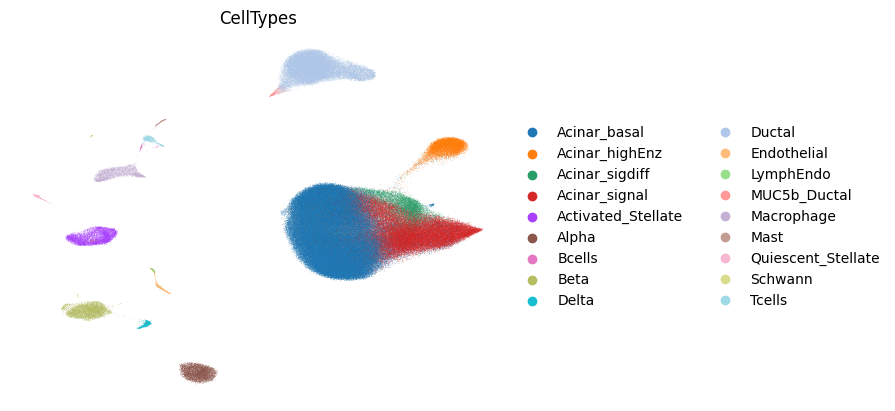

In [5]:
sc.pl.umap(adata_sc, color='CellTypes',frameon=False)

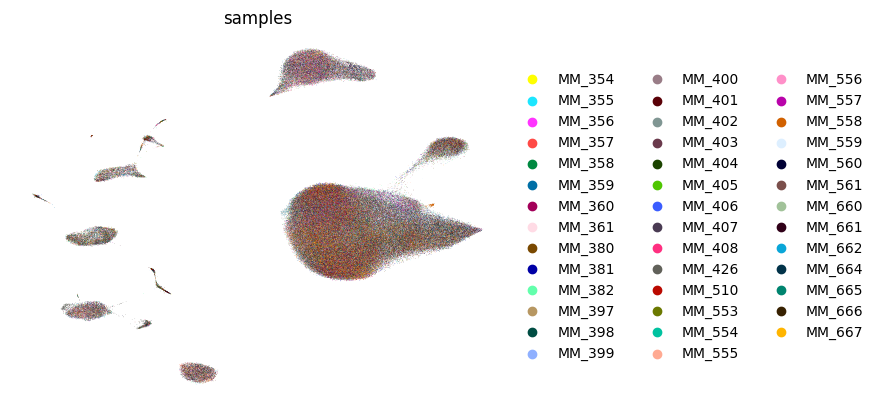

In [6]:
sc.pl.umap(adata_sc, color=['samples'],ncols=1,frameon=False)

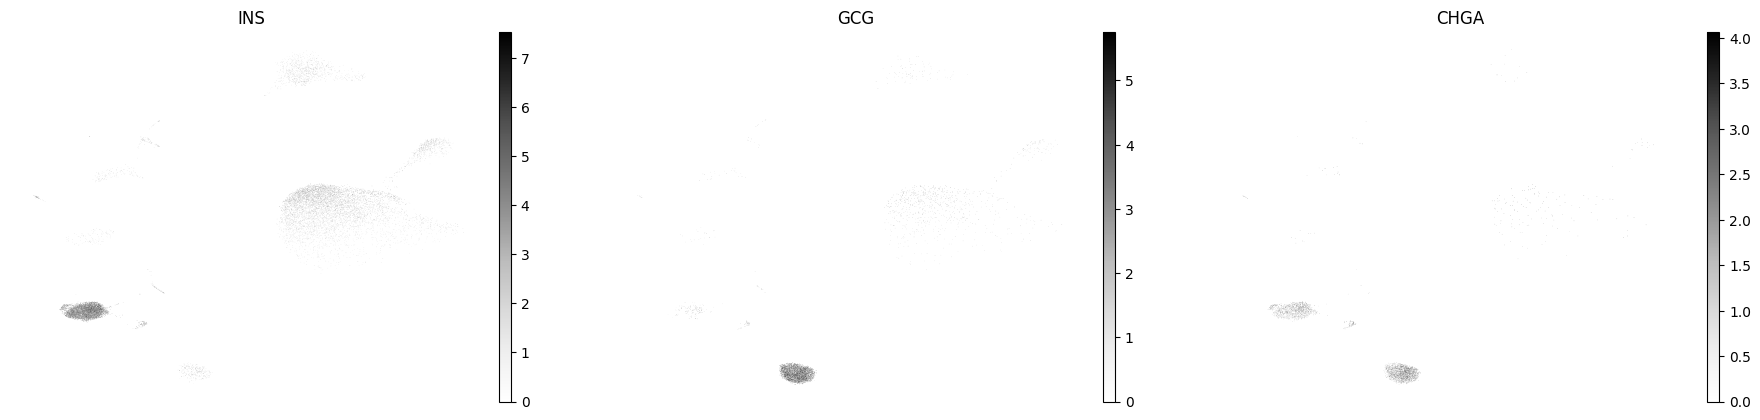

In [7]:
sc.pl.umap(adata_sc, color=['INS','GCG','CHGA'],frameon=False,cmap='Greys')

In [8]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=5000,
    subset=True,
    #layer='counts',
    #batch_key='nPOD_ID'#when using sample --> INS isn't kept 
)
adata_sc

AnnData object with n_obs × n_vars = 276906 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CellTypes_colors', 'samples_colors', 'hvg'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

Pseudobulk dissociated data

In [9]:
import decoupler as dc

In [10]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata_sc,
    sample_col='samples',
    groups_col='CellTypes',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata

AnnData object with n_obs × n_vars = 511 × 5000
    obs: 'samples', 'sex', 'condition', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'conditionSubtype', 'CellTypes', 'psbulk_n_cells', 'psbulk_counts'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'psbulk_props'

In [11]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
#dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

In [12]:
adata_sc.obs['CellTypes'].cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal',
       'Activated_Stellate', 'Alpha', 'Bcells', 'Beta', 'Delta', 'Ductal',
       'Endothelial', 'LymphEndo', 'MUC5b_Ductal', 'Macrophage', 'Mast',
       'Quiescent_Stellate', 'Schwann', 'Tcells'],
      dtype='object')

In [13]:
pdata.uns['CellTypes_colors'] = [
    '#4FB3AA',#'Acinar_basal'
    '#005F73',#'Acinar_highEnz', 
    '#0A9396',#'Acinar_sigdiff', 
    '#5FD3CF',#'Acinar_signal',
    '#e07a5f',#'Activated_Stellate', 
    '#b5838d',#'Alpha', 
    '#f8ad9d',#'Bcells', 
    '#ffd6ff',#'Beta', 
    '#c8b6ff',#'Delta', 
    '#bde0fe',#'Ductal',
    '#f2cc8f',#'Endothelial', 
    '#ffa62b',#'LymphEndo', 
    '#6096ba',#'MUC5b_Ductal', 
    '#8d0801',#'Macrophage', 
    '#4f000b',#'Mast',
    '#ff7f51',#'Quiescent_Stellate', 
    '#ce4257',#'Schwann', 
    '#e5383b',#'Tcells'
]

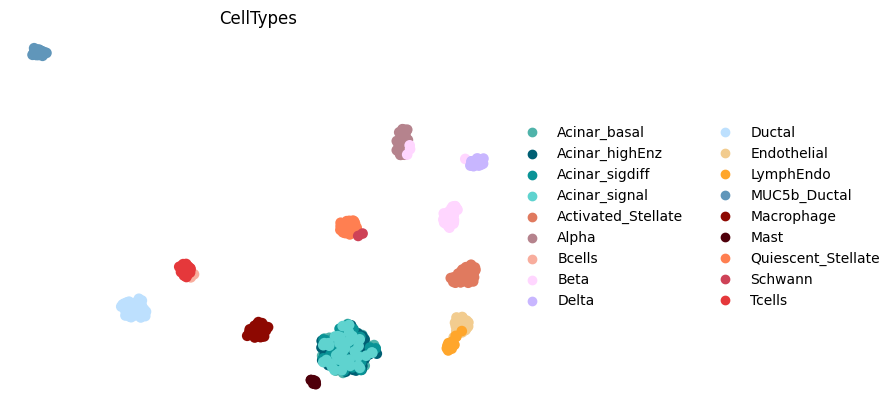

In [14]:
sc.pp.neighbors(pdata)
sc.tl.umap(pdata)
sc.pl.umap(pdata, color='CellTypes', frameon=False)

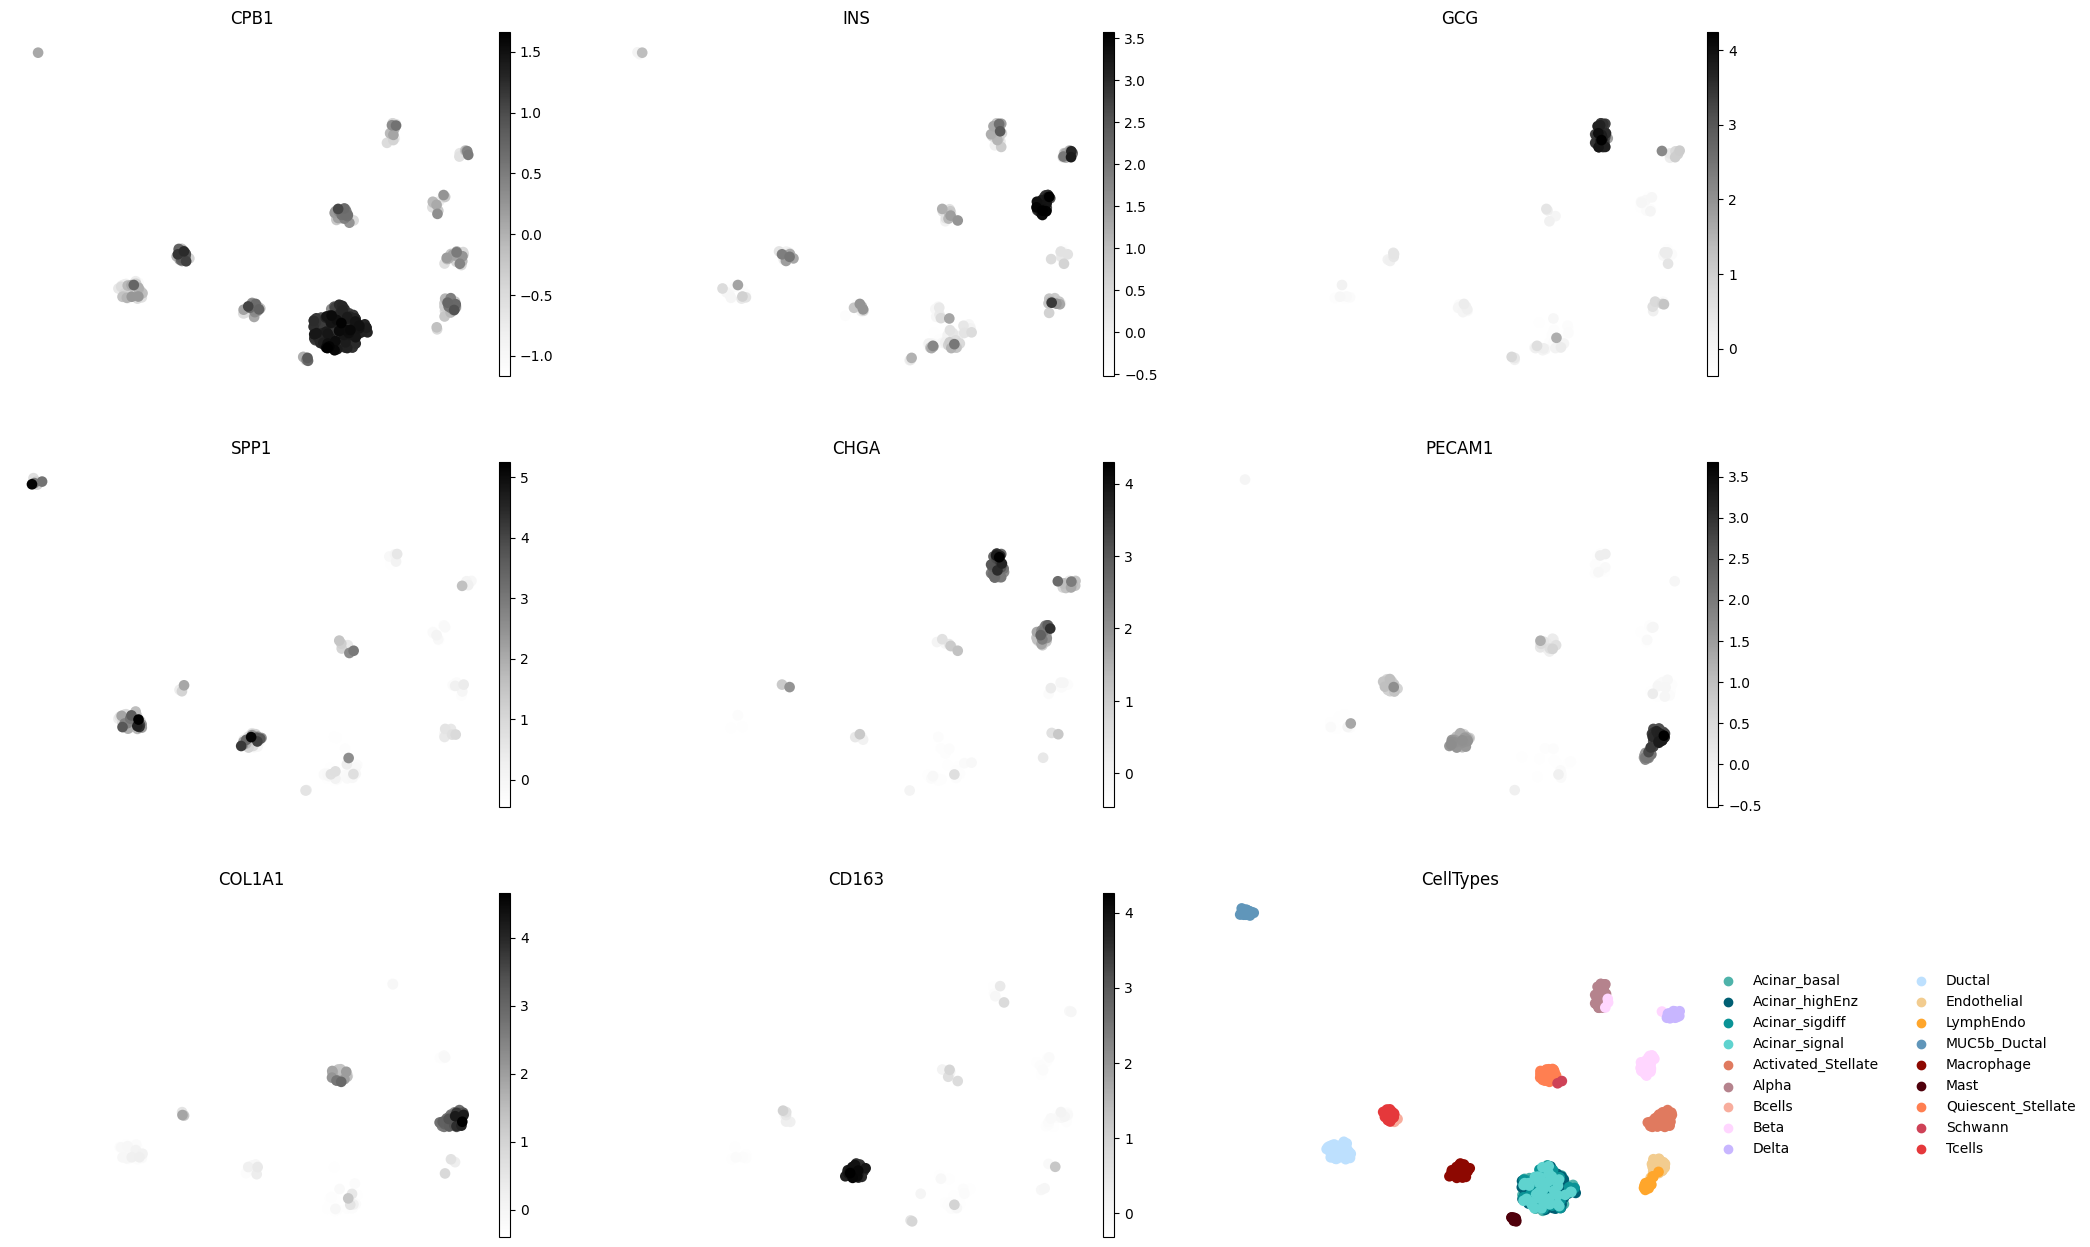

In [15]:
# 'CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163'
sc.pl.umap(pdata,color=['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163','CellTypes'],
          ncols=3,cmap='Greys',frameon=False)

In [16]:
adata_s1

AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

### Subset to FOVs and pre-process

In [17]:
adata_10 = adata_s1[np.isin(adata_s1.obs['fov'],['10'])].copy()
adata_12 = adata_s1[np.isin(adata_s1.obs['fov'],['12'])].copy()

adata_10, adata_12

(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_coarse_colors'
     obsm: 'spatial', 'spatial_fov'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 5208 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_g

In [18]:
sc.pp.pca(adata_10)
sc.pp.neighbors(adata_10)
sc.tl.umap(adata_10)

sc.pp.pca(adata_12)
sc.pp.neighbors(adata_12)
sc.tl.umap(adata_12)

### Preprare and solve the mapping problem 

In [19]:
genes = pd.read_csv('../../../../spatial_pancreas_data/preprocessed_data/genes2impute.txt', delimiter='\t', header=None)
genes2impute = list(genes[(np.isin(genes[0],adata_sc.var_names))][0])
control_markers = pd.DataFrame(['CPB1','INS','GCG','SPP1','CHGA','PECAM1','COL1A1','CD163'])
markers2impute = list(control_markers[np.isin(control_markers,adata_sc.var_names)][0])
genes2impute = genes2impute + markers2impute

In [20]:
markers2impute

['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

In [21]:
# Leave the control genes out of the fitting
adata_10_mp = adata_10[:,~adata_10.var_names.isin(markers2impute)].copy()
adata_12_mp = adata_12[:,~adata_12.var_names.isin(markers2impute)].copy()

In [22]:
params = {
    'epsilon': [0.01,0.05,0.1],#[0.05, 0.1], #0.01 default 
    'alpha': [0.2,0.3,0.4,0.5],#[0.2,0.3], #0.5 default
    'tau_a': [0.999, 0.995, 0.990, 0.900],#[1, 0.999, 0.995, 0.990, 0.900], #0.990 default
    'tau_b': [0.999, 0.995, 0.990, 0.900]#[1, 0.999, 0.995, 0.990, 0.900] #0.990 default
}

In [23]:
from sklearn.metrics import f1_score

In [24]:
evaluation = []
for tau_a in params['tau_a']:
    for tau_b in params['tau_b']:
        for alpha in params['alpha']:
            for epsilon in params['epsilon']:
                
                #prepare mapping problem
                mp = MappingProblem(adata_sc=pdata, adata_sp=adata_10_mp)
                mp = mp.prepare(
                    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
                    callback="local-pca" if adata_10.shape[1] > 100 else None,
                    kwargs = {'callback_kwargs': 'local_pca','joint-space': True},
                    spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
                    cost = 'cosine',#'cosine', #'sq_euclidean', 
                    joint_attr = {'attr':'X'}, #'X_pca' {'attr':'X_pca'}
                )
                #solve mapping problem 
                mp = mp.solve(alpha=alpha,epsilon=epsilon,tau_a=tau_a,tau_b=tau_b)
                
                #evaluating the mapping problem through imputation
                adata_imputed = mp.impute(var_names=genes2impute)
                correlations_hallmark_genes = []

                for i in markers2impute:
                    gene = i
                    obs_genes = adata_10[:,[gene]].X.copy().toarray().flatten()
                    imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
                    correlation, p_value = pearsonr(obs_genes, imp_genes)
                    row_data = {
                        'gene' : gene,
                        'Pearson_correlation' : correlation,
                        'P_value' : p_value
                    }
                    correlations_hallmark_genes.append(row_data)
                
                df = pd.DataFrame(correlations_hallmark_genes)
                #'CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163'
                #print('-----------------------------------------------------------') 
                row_data = {
                    'tau_a' : tau_a,
                    'tau_b' : tau_b,
                    'alpha' : alpha,
                    'epsilon' : epsilon, 
                    'cpb1_corr' : df.loc[df['gene'] == 'CPB1', 'Pearson_correlation'].values[0],
                    'ins_corr' : df.loc[df['gene'] == 'INS', 'Pearson_correlation'].values[0],
                    'gcg_corr' : df.loc[df['gene'] == 'GCG', 'Pearson_correlation'].values[0],
                    'spp1_corr' : df.loc[df['gene'] == 'SPP1', 'Pearson_correlation'].values[0],
                    'chga_corr' : df.loc[df['gene'] == 'CHGA', 'Pearson_correlation'].values[0],
                    'pecam1_corr' : df.loc[df['gene'] == 'PECAM1', 'Pearson_correlation'].values[0],
                    'col1a1_corr' : df.loc[df['gene'] == 'COL1A1', 'Pearson_correlation'].values[0],
                    'cd163_corr' : df.loc[df['gene'] == 'CD163', 'Pearson_correlation'].values[0],
                    'mean_corr' : df['Pearson_correlation'].mean()
                }
                evaluation.append(row_data)
                del mp
                del adata_imputed
df_10 = pd.DataFrame(evaluation)
df_10

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           


/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           


/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           


/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           


/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           


/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           


/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           


/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].

/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2480356151.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
WARNING  Solver did not converge                                                                                   


tau_a  tau_b  alpha  epsilon  cpb1_corr  ins_corr  gcg_corr  spp1_corr  \
0    0.999  0.999    0.2     0.01   0.396652  0.447120  0.467975   0.173618   
1    0.999  0.999    0.2     0.05   0.445845  0.562415  0.569791   0.235533   
2    0.999  0.999    0.2     0.10   0.521936  0.656844  0.696030   0.271356   
3    0.999  0.999    0.3     0.01   0.404967  0.459605  0.466368   0.186388   
4    0.999  0.999    0.3     0.05   0.499375  0.635210  0.662270   0.264959   
..     ...    ...    ...      ...        ...       ...       ...        ...   
187  0.900  0.900    0.4     0.05        NaN       NaN       NaN        NaN   
188  0.900  0.900    0.4     0.10   0.724734  0.768432  0.844825   0.284168   
189  0.900  0.900    0.5     0.01        NaN       NaN       NaN        NaN   
190  0.900  0.900    0.5     0.05   0.684211  0.777715  0.868808   0.261753   
191  0.900  0.900    0.5     0.10   0.742307  0.761188  0.803254   0.302431   

     chga_corr  pecam1_corr  col1a1_corr  cd163_corr  mean_corr  
0     0.472764     0.119754     0.229998    0.116485   0.303046  
1     0.556565     0.138642     0.259292    0.159654   0.365967  
2     0.666007     0.169580     0.284057    0.211301   0.434639  
3     0.470629     0.116805     0.232453    0.124264   0.307685  
4     0.632778     0.160398     0.276492    0.194012   0.415687  
..         ...          ...          ...         ...        ...  
187        NaN          NaN          NaN         NaN        NaN  
188   0.782526     0.175939     0.305618    0.254274   0.517565  
189        NaN          NaN          NaN         NaN        NaN  
190   0.805419     0.155722     0.293985    0.197668   0.505660  
191   0.750238     0.157024     0.294276    0.229501   0.505027  

[192 rows x 13 columns]

In [25]:
evaluation = []
for tau_a in params['tau_a']:
    for tau_b in params['tau_b']:
        for alpha in params['alpha']:
            for epsilon in params['epsilon']:
                
                #prepare mapping problem
                mp = MappingProblem(adata_sc=pdata, adata_sp=adata_12_mp)
                mp = mp.prepare(
                    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
                    callback="local-pca" if adata_12.shape[1] > 100 else None,
                    kwargs = {'callback_kwargs': 'local_pca','joint-space': True},
                    spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
                    cost = 'cosine',#'cosine', #'sq_euclidean', 
                    joint_attr = {'attr':'X'}, #'X_pca' {'attr':'X_pca'}
                )
                #solve mapping problem 
                mp = mp.solve(alpha=alpha,epsilon=epsilon,tau_a=tau_a,tau_b=tau_b)
                
                #evaluating the mapping problem through imputation
                adata_imputed = mp.impute(var_names=genes2impute)
                correlations_hallmark_genes = []

                for i in markers2impute:
                    gene = i
                    obs_genes = adata_12[:,[gene]].X.copy().toarray().flatten()
                    imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
                    correlation, p_value = pearsonr(obs_genes, imp_genes)
                    row_data = {
                        'gene' : gene,
                        'Pearson_correlation' : correlation,
                        'P_value' : p_value
                    }
                    correlations_hallmark_genes.append(row_data)
                
                df = pd.DataFrame(correlations_hallmark_genes)
                #'CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163'
                #print('-----------------------------------------------------------') 
                row_data = {
                    'tau_a' : tau_a,
                    'tau_b' : tau_b,
                    'alpha' : alpha,
                    'epsilon' : epsilon, 
                    'cpb1_corr' : df.loc[df['gene'] == 'CPB1', 'Pearson_correlation'].values[0],
                    'ins_corr' : df.loc[df['gene'] == 'INS', 'Pearson_correlation'].values[0],
                    'gcg_corr' : df.loc[df['gene'] == 'GCG', 'Pearson_correlation'].values[0],
                    'spp1_corr' : df.loc[df['gene'] == 'SPP1', 'Pearson_correlation'].values[0],
                    'chga_corr' : df.loc[df['gene'] == 'CHGA', 'Pearson_correlation'].values[0],
                    'pecam1_corr' : df.loc[df['gene'] == 'PECAM1', 'Pearson_correlation'].values[0],
                    'col1a1_corr' : df.loc[df['gene'] == 'COL1A1', 'Pearson_correlation'].values[0],
                    'cd163_corr' : df.loc[df['gene'] == 'CD163', 'Pearson_correlation'].values[0],
                    'mean_corr' : df['Pearson_correlation'].mean()
                }
                evaluation.append(row_data)
                del mp
                del adata_imputed
df_12 = pd.DataFrame(evaluation)
df_12

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           


/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           


/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                        

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           


/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           


/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           


/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           


/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           


/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                                                                   
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].

/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(obs_genes, imp_genes)
/tmp/ipykernel_2512462/2883241907.py:28: Cons

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           
WARNING  Solver did not converge                                                                                   


tau_a  tau_b  alpha  epsilon  cpb1_corr  ins_corr  gcg_corr  spp1_corr  \
0    0.999  0.999    0.2     0.01   0.500828  0.483441  0.789582   0.103694   
1    0.999  0.999    0.2     0.05   0.548452  0.576111  0.841893   0.131797   
2    0.999  0.999    0.2     0.10   0.605052  0.666134  0.877835   0.148194   
3    0.999  0.999    0.3     0.01   0.519800  0.495688  0.816117   0.115954   
4    0.999  0.999    0.3     0.05   0.597262  0.644038  0.877109   0.147920   
..     ...    ...    ...      ...        ...       ...       ...        ...   
187  0.900  0.900    0.4     0.05        NaN       NaN       NaN        NaN   
188  0.900  0.900    0.4     0.10   0.783988  0.818325  0.939378   0.156808   
189  0.900  0.900    0.5     0.01        NaN       NaN       NaN        NaN   
190  0.900  0.900    0.5     0.05   0.765990  0.813368  0.940686   0.152772   
191  0.900  0.900    0.5     0.10   0.798342  0.819130  0.921271   0.169030   

     chga_corr  pecam1_corr  col1a1_corr  cd163_corr  mean_corr  
0     0.753933     0.176102     0.251433    0.324120   0.422892  
1     0.811975     0.199481     0.294470    0.374355   0.472317  
2     0.865594     0.225230     0.336491    0.449124   0.521707  
3     0.766426     0.171052     0.250582    0.321730   0.432169  
4     0.852099     0.211968     0.322983    0.427250   0.510078  
..         ...          ...          ...         ...        ...  
187        NaN          NaN          NaN         NaN        NaN  
188   0.897556     0.229297     0.392500    0.492523   0.588797  
189        NaN          NaN          NaN         NaN        NaN  
190   0.913961     0.203050     0.370675    0.462514   0.577877  
191   0.872343     0.214132     0.387694    0.459212   0.580144  

[192 rows x 13 columns]

In [26]:
# Find the index label corresponding to the maximum value in a specific column
max_index_10 = df_10['mean_corr'].idxmax()

# Retrieve the values of the row with the maximum value in the column
max_row_values_10 = df_10.loc[max_index_10]

# Print the values
print(max_row_values_10)

tau_a          0.995000
tau_b          0.900000
alpha          0.500000
epsilon        0.100000
cpb1_corr      0.719243
ins_corr       0.768731
gcg_corr       0.851914
spp1_corr      0.280563
chga_corr      0.790483
pecam1_corr    0.177190
col1a1_corr    0.305947
cd163_corr     0.253193
mean_corr      0.518408
Name: 95, dtype: float64


In [27]:
# Find the index label corresponding to the maximum value in a specific column
max_index_12 = df_12['mean_corr'].idxmax()

# Retrieve the values of the row with the maximum value in the column
max_row_values_12 = df_12.loc[max_index_12]

# Print the values
print(max_row_values_12)

tau_a          0.990000
tau_b          0.900000
alpha          0.500000
epsilon        0.100000
cpb1_corr      0.784778
ins_corr       0.818495
gcg_corr       0.941650
spp1_corr      0.155439
chga_corr      0.902681
pecam1_corr    0.229447
col1a1_corr    0.389662
cd163_corr     0.490479
mean_corr      0.589079
Name: 143, dtype: float64


### Analysis of the transport plan with the best set of found parameters

In [28]:
best_param_10 = max_row_values_10.to_dict()
best_param_12 = max_row_values_12.to_dict()
best_param_10, best_param_12

({'tau_a': 0.995,
  'tau_b': 0.9,
  'alpha': 0.5,
  'epsilon': 0.1,
  'cpb1_corr': 0.719242859910583,
  'ins_corr': 0.7687307132882433,
  'gcg_corr': 0.8519143129878931,
  'spp1_corr': 0.2805630216619026,
  'chga_corr': 0.7904830280660887,
  'pecam1_corr': 0.17718997207741807,
  'col1a1_corr': 0.3059467533538889,
  'cd163_corr': 0.2531929335336757,
  'mean_corr': 0.5184079493599617},
 {'tau_a': 0.99,
  'tau_b': 0.9,
  'alpha': 0.5,
  'epsilon': 0.1,
  'cpb1_corr': 0.7847775243337924,
  'ins_corr': 0.8184953578084736,
  'gcg_corr': 0.9416502057160504,
  'spp1_corr': 0.15543855047344238,
  'chga_corr': 0.9026806039151902,
  'pecam1_corr': 0.2294466049956004,
  'col1a1_corr': 0.3896619779127375,
  'cd163_corr': 0.49047879547950857,
  'mean_corr': 0.5890787025793495})

In [29]:
mp_10 = MappingProblem(adata_sc=pdata, adata_sp=adata_10)
mp_10 = mp_10.prepare(
    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
    callback="local-pca" if adata_10.shape[1] > 100 else None,
    kwargs = {'callback_kwargs': 'local_pca', 'joint-space': True},
    spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
    cost = 'cosine', #'sq_euclidean', 
    joint_attr = {"attr":"X"} #'X_pca' {'attr':'X_pca'}
)
#solve mapping problem 
mp_10 = mp_10.solve(alpha=best_param_10['alpha'],epsilon=best_param_10['epsilon'],tau_a=best_param_10['tau_a'],tau_b=best_param_10['tau_b'])

mp_12 = MappingProblem(adata_sc=pdata, adata_sp=adata_12)
mp_12 = mp_12.prepare(
    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
    callback="local-pca" if adata_12.shape[1] > 100 else None,
    kwargs = {'callback_kwargs': 'local_pca', 'joint-space': True},
    spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
    cost = 'cosine', #'sq_euclidean', 
    joint_attr = {"attr":"X"} #'X_pca' {'attr':'X_pca'}
)
#solve mapping problem 
mp_12 = mp_12.solve(alpha=best_param_12['alpha'],epsilon=best_param_12['epsilon'],tau_a=best_param_12['tau_a'],tau_b=best_param_12['tau_b'])

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 511)].                                           
INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 511)].                                           


#### Imputation

In [30]:
# impute the 5k HVG from sc data 

start_time = time.time()

adatas_imputed_10 = []
for i in range(int(len(pdata.var_names)/20)):
    adata_imputed_10 = mp_10.impute(var_names=pdata.var_names[i*20:i*20+20],device='cuda:0')
    adatas_imputed_10.append(adata_imputed_10)
    del adata_imputed_10

adatas_imputed_12 = []
for i in range(int(len(pdata.var_names)/20)):
    adata_imputed_12 = mp_12.impute(var_names=pdata.var_names[i*20:i*20+20],device='cuda:0')
    adatas_imputed_12.append(adata_imputed_12)
    del adata_imputed_12

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 16.95734977722168 seconds


In [31]:
import anndata as ad
adata_imputed_10  = ad.concat(adatas_imputed_10, join='outer',uns_merge='same',axis=1)
adata_imputed_12  = ad.concat(adatas_imputed_12, join='outer',uns_merge='same',axis=1)

adata_imputed_10, adata_imputed_12

(AnnData object with n_obs × n_vars = 4423 × 5000,
 AnnData object with n_obs × n_vars = 5208 × 5000)

In [32]:
adata_10, adata_12

(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap'
     obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'distances', 'connectivit

In [33]:
adata_imputed_10.uns['spatial'] = adata_10.uns['spatial']
adata_imputed_10.obsm['spatial'] = adata_10.obsm['spatial']
adata_imputed_10.obs['fov'] = adata_10.obs['fov']
adata_imputed_10.obs['cell_ID'] = adata_10.obs['cell_ID']  

adata_imputed_12.uns['spatial'] = adata_12.uns['spatial']
adata_imputed_12.obsm['spatial'] = adata_12.obsm['spatial']
adata_imputed_12.obs['fov'] = adata_12.obs['fov']
adata_imputed_12.obs['cell_ID'] = adata_12.obs['cell_ID']  

adata_imputed_10, adata_imputed_12

(AnnData object with n_obs × n_vars = 4423 × 5000
     obs: 'fov', 'cell_ID'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 5208 × 5000
     obs: 'fov', 'cell_ID'
     uns: 'spatial'
     obsm: 'spatial')

Plotting imputed gene expression

In [34]:
markers2impute

['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

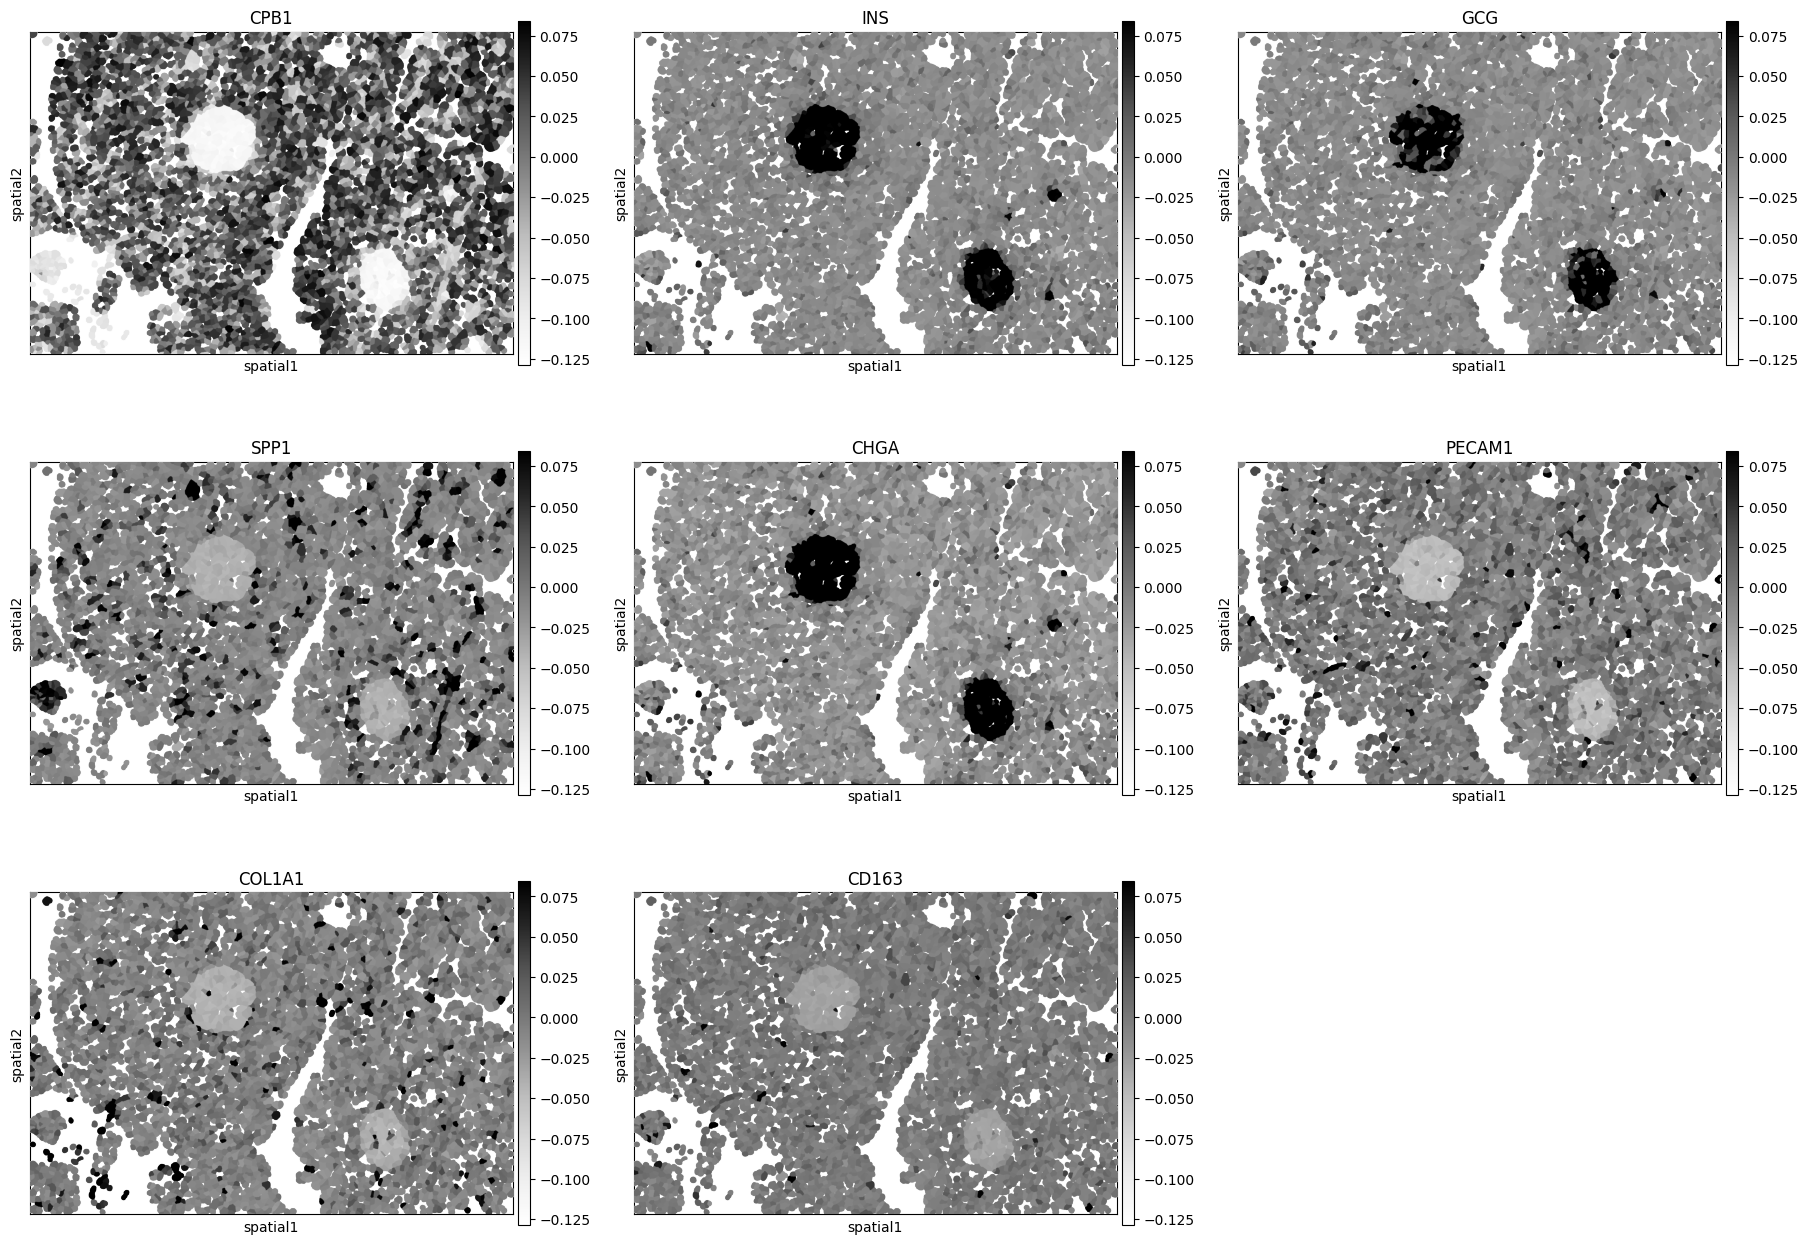

In [35]:
sq.pl.spatial_segment(adata_imputed_10,color=markers2impute,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

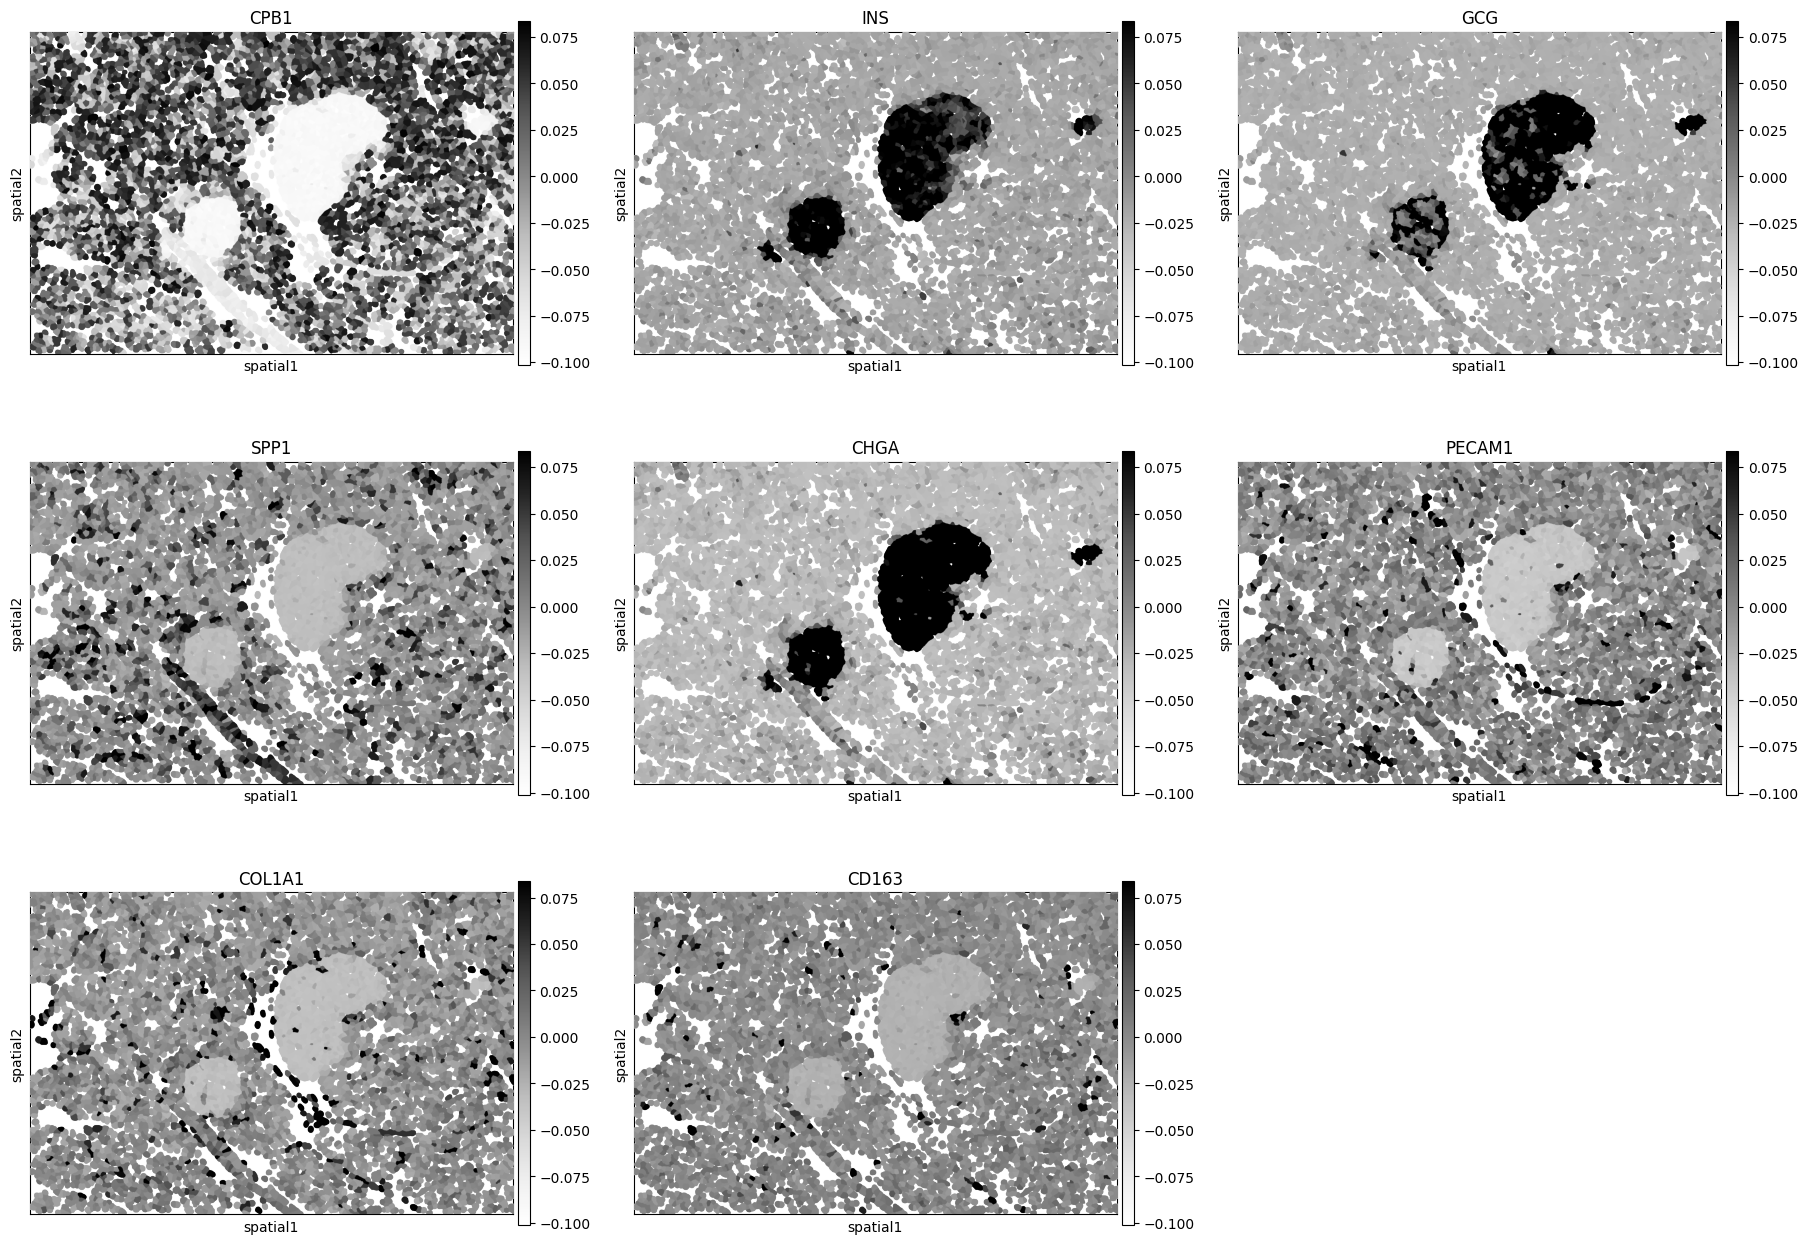

In [36]:
sq.pl.spatial_segment(adata_imputed_12,color=markers2impute,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

#### Annotation mapping

In [37]:
mp_10[("src", "tgt")]

OTProblem[stage='solved', shape=(4423, 511)]

In [38]:
mp_12[("src", "tgt")]

OTProblem[stage='solved', shape=(5208, 511)]

In [39]:
type(pdata.obs.CellTypes)

pandas.core.series.Series

In [40]:
pdata.obs.cell_type = pdata.obs.CellTypes.astype("category")

Annotation mapping using “max” mode

In [41]:
start_time = time.time()

anno_map_max_10 = mp_10.annotation_mapping(
    "max",
    "CellTypes",
    source="src",
    #target="tgt",
    forward=False,
    batch_size=256,
)

anno_map_max_12 = mp_12.annotation_mapping(
    "max",
    "CellTypes",
    source="src",
    #target="tgt",
    forward=False,
    batch_size=256,
)

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 10.099384307861328 seconds


In [42]:
adata_10.obs["CellTypes_max"] = anno_map_max_10["CellTypes"].values
adata_10.obs["CellTypes_max"] = adata_10.obs["CellTypes_max"].astype("category")

adata_12.obs["CellTypes_max"] = anno_map_max_12["CellTypes"].values
adata_12.obs["CellTypes_max"] = adata_12.obs["CellTypes_max"].astype("category")

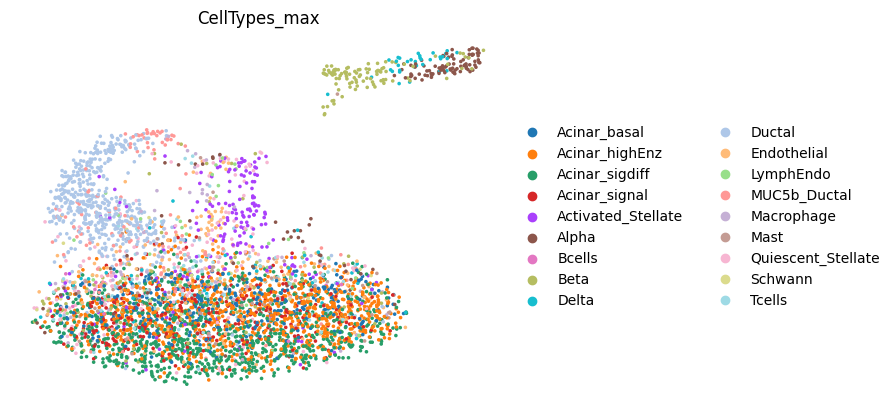

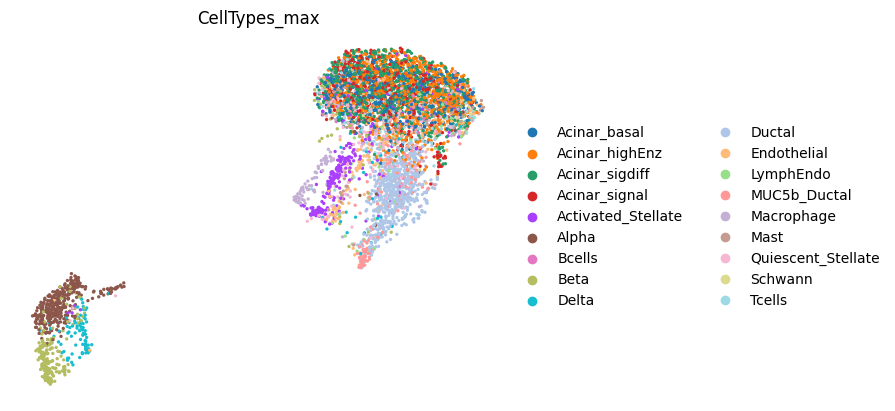

In [43]:
#sc.pl.umap(adata_sc, color="cell_type")
sc.pl.umap(adata_10, color=["CellTypes_max"], frameon=False)
sc.pl.umap(adata_12, color=["CellTypes_max"], frameon=False)

In [45]:
adata_10.uns['CellTypes_max_colors'] = [
    '#4FB3AA',#'Acinar_basal'
    '#005F73',#'Acinar_highEnz', 
    '#0A9396',#'Acinar_sigdiff', 
    '#5FD3CF',#'Acinar_signal',
    '#e07a5f',#'Activated_Stellate', 
    '#b5838d',#'Alpha', 
    '#f8ad9d',#'Bcells', 
    '#ffd6ff',#'Beta', 
    '#c8b6ff',#'Delta', 
    '#bde0fe',#'Ductal',
    '#f2cc8f',#'Endothelial', 
    '#ffa62b',#'LymphEndo', 
    '#6096ba',#'MUC5b_Ductal', 
    '#8d0801',#'Macrophage', 
    '#4f000b',#'Mast',
    '#ff7f51',#'Quiescent_Stellate', 
    '#ce4257',#'Schwann', 
    '#e5383b',#'Tcells'
]

adata_12.uns['CellTypes_max_colors'] = [
    '#4FB3AA',#'Acinar_basal'
    '#005F73',#'Acinar_highEnz', 
    '#0A9396',#'Acinar_sigdiff', 
    '#5FD3CF',#'Acinar_signal',
    '#e07a5f',#'Activated_Stellate', 
    '#b5838d',#'Alpha', 
    '#f8ad9d',#'Bcells', 
    '#ffd6ff',#'Beta', 
    '#c8b6ff',#'Delta', 
    '#bde0fe',#'Ductal',
    '#f2cc8f',#'Endothelial', 
    '#ffa62b',#'LymphEndo', 
    '#6096ba',#'MUC5b_Ductal', 
    '#8d0801',#'Macrophage', 
    '#4f000b',#'Mast',
    '#ff7f51',#'Quiescent_Stellate', 
    '#ce4257',#'Schwann', 
    '#e5383b',#'Tcells'
]

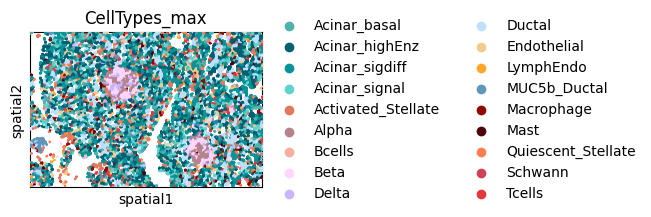

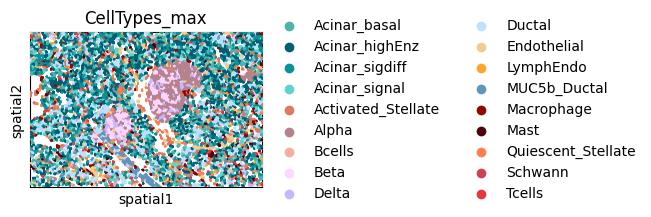

In [46]:
sq.pl.spatial_segment(adata_10,color='CellTypes_max',size=5,library_key='fov', seg_cell_id='cell_ID', img=False)

sq.pl.spatial_segment(adata_12,color='CellTypes_max',size=5,library_key='fov', seg_cell_id='cell_ID', img=False)

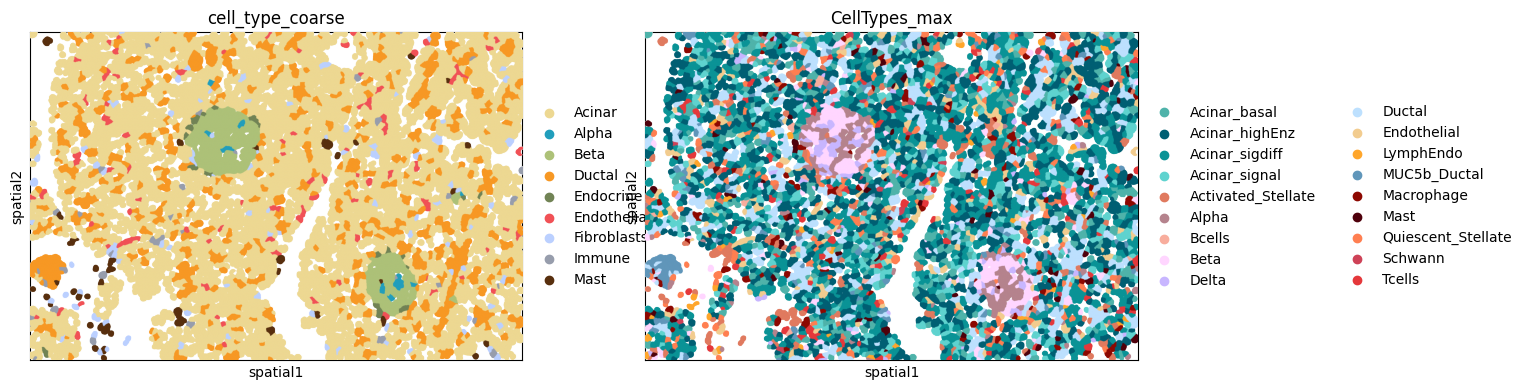

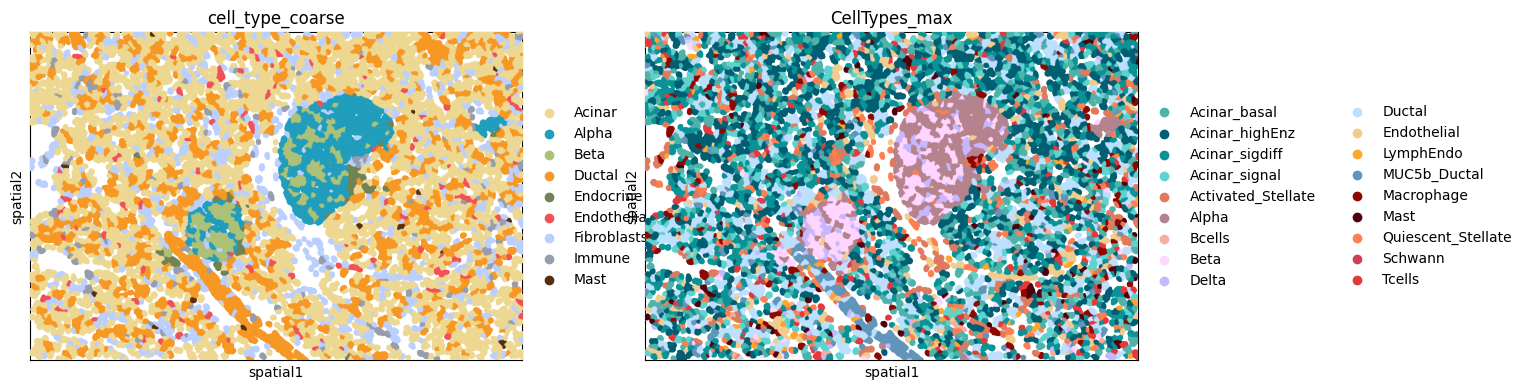

In [47]:
sq.pl.spatial_segment(adata_10,color=['cell_type_coarse','CellTypes_max'],size=5,ncols=2,library_key='fov', seg_cell_id='cell_ID',img=False)
sq.pl.spatial_segment(adata_12,color=['cell_type_coarse','CellTypes_max'],size=5,ncols=2,library_key='fov', seg_cell_id='cell_ID',img=False)

In [48]:
adata_10, adata_12

(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap', 'CellTypes_max_colors'
     obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'cou

In [49]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'

adata_10.write(folder+'adata_fov_10_npod_annotation.h5ad')
adata_12.write(folder+'adata_fov_12_npod_annotation.h5ad')

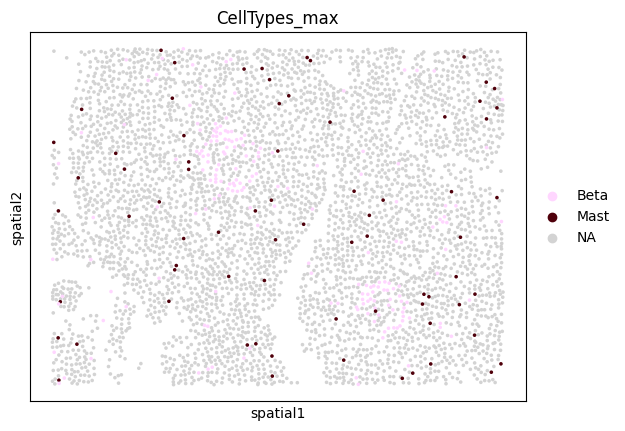

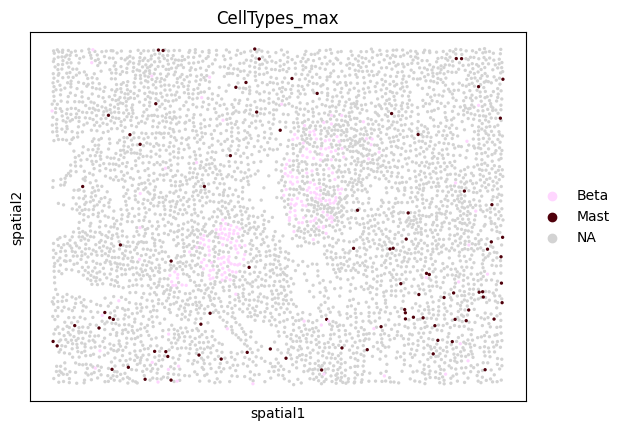

In [51]:
sc.pl.embedding(adata_10,color=['CellTypes_max'],groups=['Beta','Mast'],basis='spatial')
sc.pl.embedding(adata_12,color=['CellTypes_max'],groups=['Beta','Mast'],basis='spatial')

In [57]:
sq.gr.spatial_neighbors(
    adata_sp_fov_12,
    n_neighs=15,
    coord_type="generic",
    delaunay=True,
)

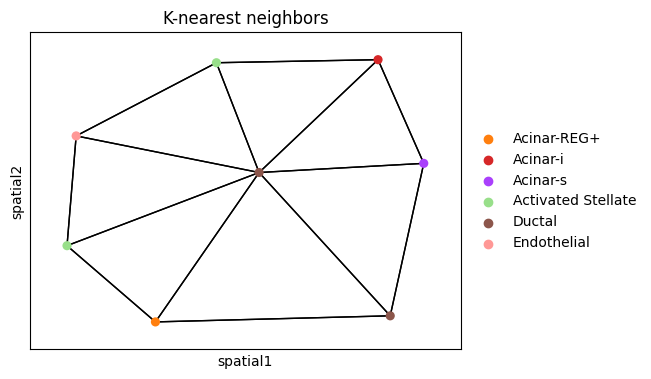

In [58]:
_, idx = adata_sp_fov_12.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata_sp_fov_12[idx,420],
    library_id = '12',
    color="Cluster_max",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="K-nearest neighbors"
)

In [59]:
sq.gr.nhood_enrichment(adata_sp_fov_12,cluster_key='Cluster_max')

  0%|          | 0/1000 [00:00<?, ?/s]/home/aih/sara.jimenez/miniconda3/envs/moscot_v2/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [00:01<00:00, 848.79/s]


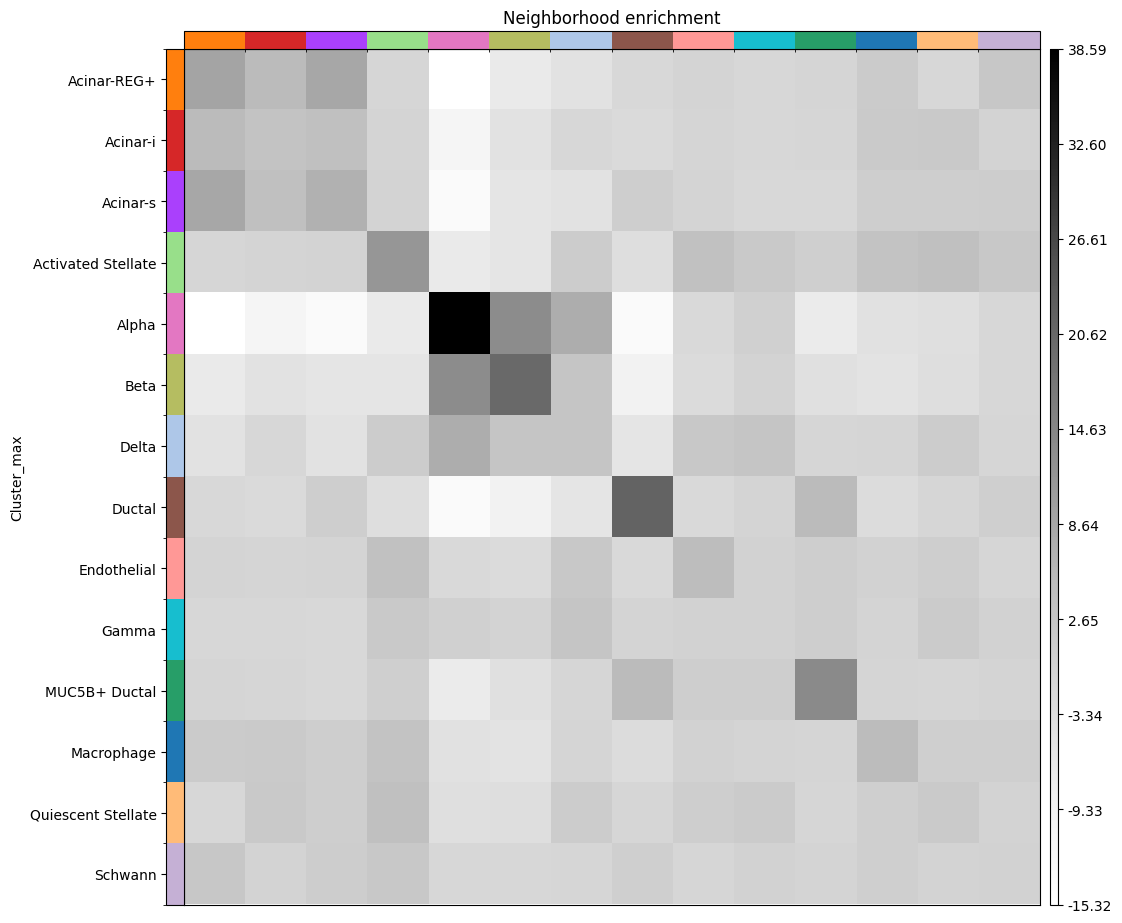

In [60]:
sq.pl.nhood_enrichment(adata_sp_fov_12, cluster_key='Cluster_max',cmap='Greys')

In [61]:
sq.gr.interaction_matrix(adata_sp_fov_12, cluster_key='Cluster_max',weights=True)

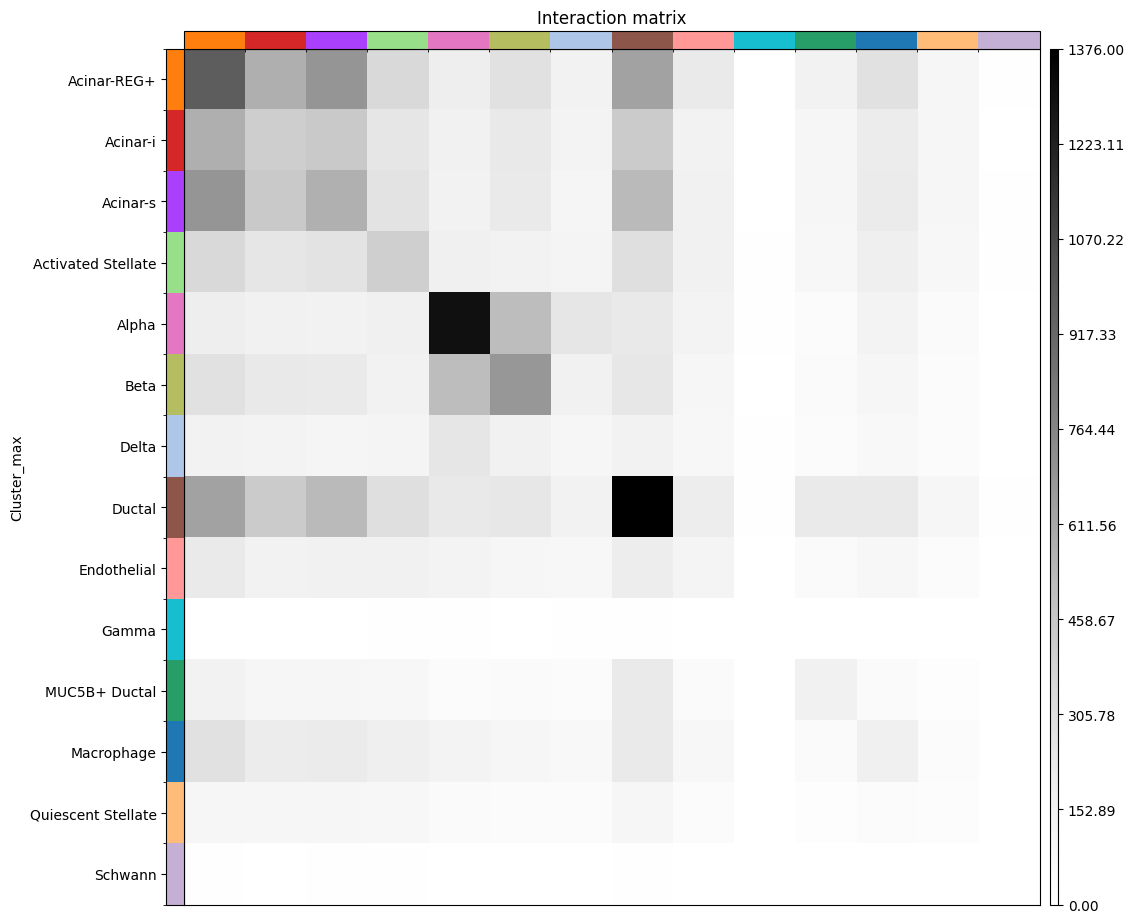

In [62]:
sq.pl.interaction_matrix(adata_sp_fov_12, cluster_key='Cluster_max',cmap='Greys')